# Project of Computational Statistics: B-splines

## Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

## my_data class  ->  Starting point dataset

In [79]:
class my_data():
    """Data structure of either simulated or real datasets ready to feed the B-spline method."""
    
    def __init__(self, x=None, y=None):
        
        """Initialization of the dataset.
        data -> imported dataset
        """
        if x is None or y is None:
            return
        self.init_point = min(x)
        self.final_point = max(x)
        self.signal = None
        self.x = x
        self.y = y
        
        
    def simulateData(self, n_points=1500, init_point=0, final_point=1, signal=None):
        """
        Simulation of the dataset.
        init_point -> start of the observational window
        final_point -> end of the observational window
        signal -> function representing the main signal
        n_points -> Number of point to generate
        """
        x = np.random.rand(n_points) * (final_point - init_point) + init_point
        self.x = np.sort(x, axis=None)
        
        self.init_point = init_point
        self.final_point = final_point
        
        self.signal = signal
        if signal is None:
            signal = lambda x: 0
        self.signal = np.array(list(map(signal, self.x)))
        self.y = self.signal.copy()
        
    
    def addNoise(self, distribution='', devstd=0):
        """
        Noise addition.
        distribution -> distribution of the noise
        devstd -> standard deviation (applicable if the distribution is ie. a gaussian one)
        """
        distribution = distribution.lower().replace(" ", "")
        if distribution == '':
            distribution = 'gaussian'
        if devstd < 0:
            devstd = 0
        
        if distribution == 'gaussian':
            self.y = np.random.normal(self.signal, size = len(self.x), scale=devstd)
        elif distribution == 'poisson':
            self.y = np.random.poisson(self.signal, size = len(self.x))
            if min(self.y) < 0:
                self.y += min(self.y)
        else:
            raise Exception('my_data Noise -> Invalid distribution type.')

    
    def shrinked_Dataset(self, n):
        """
        Returns the original dataset with a removed subset.
        n -> number of point to remove
        """
        index = np.array((range(len(self.x))))
        np.random.shuffle(index)
        x = np.delete(self.x, index[:n])
        y = np.delete(self.y, index[:n])
        return my_data(x, y)

    
    def plot(self):
        plt.scatter(self.x, self.y, label="data", marker='.', c='gray')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Data")
        if self.signal is not None:
            plt.plot(self.x, self.signal, label="signal", linestyle='-', c='orange', linewidth=3.0)



## B-spline class   -> All we need to create basis, fit models and plot the data

In [121]:
class B_spline():
    
    def __init__(self, dataset, K=-1, totalKnots=-1, df=-1, order=-1, K_optimization=False):
        """
        Initialize class B-spline.
        dataset -> collection of data in my_data form
        K -> number of internal knots ξ
        order -> order of spline (ie: 3 for a cubic)
        df -> total degree of freedom
        init_point -> starting point to evaluate spline
        final_point -> final point to evaluate spline
        totalKnots -> total number of knots ξ
        K_optimization -> automatically adjusts the location of the knots
        """
        self.dataset = dataset
        
        K = int(K)
        totalKnots = int(totalKnots)
        df = int(df)
        order = int(order)
        
        if K < 0: K = totalKnots - 2
        if (K <= 0 and df <= 0) or (K <= 0 and df > 0 and order < 0):
            raise Exception('BSpline init -> Invalid number of knots.')
        if K <= 0:
            K = df - order - 1
        if K < 0:
            raise Exception('BSpline init -> Invalid inputs.')
        
        self.K = K
        self.totalKnots = self.K + 2
            
        self.init_point = dataset.init_point
        self.final_point = dataset.final_point
        if self.final_point - self.init_point <= 0: 
            raise Exception('BSpline init -> Invalid initial/final points.')
        
        if df > self.K:
            order = df - self.K - 1
        elif order >= 0:
            df = order + self.K + 1
        else:
            raise Exception('BSpline init -> Invalid order/df value.')
        self.order = order
        self.df = df
        self.opt = K_optimization
        
        self.generateInternalKnots()
        self.base =  np.array([self.generate_basis(x, self.order + 1) for x in self.dataset.x])


    def generateInternalKnots(self):
        if not self.opt:
            # Uniform knots position
            self.internalKnots = np.linspace(self.init_point, self.final_point, self.totalKnots)
        else:
            # Density-dependent knots position
            data_x = self.dataset.x
            rough_spline = B_spline(self.dataset, K=40, order=1, K_optimization=False)
            rough_spline.fitGLM(response='gaussian', verbose=False, show=False)
            pred = rough_spline.predicted
            derivate = pred[1:] - pred[:-1]
            derivate = np.concatenate((derivate, np.array([derivate[-1]])))
            cumulative = np.cumsum(np.fabs(derivate))
            cumulative = cumulative / np.max(cumulative)
            y_tick = np.linspace(0, 1, self.K+2)[:-1]
            y_std = np.linspace(0, 1, len(data_x))
            x_tick = [0]
            for tick in y_tick[1:len(y_std)-1]:
                for i in range(1,len(y_std)):
                    if y_std[i] >= tick and y_std[i-1] < tick:
                        x_tick.append(i-1)
                        break
            x_tick.append(len(y_std)-1)
            self.internalKnots = data_x[x_tick]
    
    
    def generate_augmKnots(self, m):
        """
        Generates an array of Knots with repeated Knots on boundaries.
        m: degree of spline 
        """
        init_boundaries = self.init_point * np.ones(m-1)
        final_boundaries = self.final_point * np.ones(m-1)
        augmKnots = np.concatenate((init_boundaries, self.internalKnots, final_boundaries), axis = None)
        return augmKnots


    def generate_basis(self, x, m):
        """
        Generates basis spline of order m.
        x -> Input array
        m -> degree of spline 
        """
        if m==1:
            augmKnots = self.generate_augmKnots(1)

            number_of_intervals = self.K + 1
            intervals = np.zeros((number_of_intervals,2))
            for i in range(number_of_intervals):
                for j in range(2):
                    intervals[i,j] = augmKnots[i+j]
            basis_1 = [1 if (x >= intervals[i,0] and x < intervals[i,1]) else 0  
                        for i in  range(number_of_intervals)]
            basis_1 = np.array(basis_1)

            return basis_1


        augmKnots = self.generate_augmKnots(m)
        prev_basis = self.generate_basis(x, m-1)
        prev_basis = np.pad(prev_basis, (1, 1), 'constant', constant_values=(0,0))
        
        
        basis_m = np.zeros(self.K + m)
        for i in range(self.K + m):
            if augmKnots[i+m-1] == augmKnots[i]  :
                basis_m[i] = (
                ((augmKnots[i+m] - x) / (augmKnots[i+m] - augmKnots[i+1])) * prev_basis[i+1])
            elif augmKnots[i+m] == augmKnots[i+1]:  
                basis_m[i] = (
                ((x-augmKnots[i]) / (augmKnots[i+m-1] - augmKnots[i])) * prev_basis[i])
            else:
                basis_m[i] = (
                ((x-augmKnots[i]) / (augmKnots[i+m-1] - augmKnots[i])) * prev_basis[i] +
                ((augmKnots[i+m]-x) / (augmKnots[i+m] - augmKnots[i+1])) * prev_basis[i+1])
        return basis_m

    
    def fitGLM(self, response='', verbose=False, show=False, showKnots=False, show_data=True):
        """
        GLM fit to get the best coefficient estimations.
        response -> distribution of the target variable (ie. gaussian, poisson..)
        verbose -> True if the glm results should be visible
        show -> True if one wants the prediction in a graph form to be shown
        showKnots -> True if the knot positions should be displayed
        show_data -> True if one wants the original dataset to be shown
        """
        response = response.lower().replace(" ", "")
        if response == '': response = 'gaussian'
        
        if response == 'gaussian':
            self.model = sm.GLM(self.dataset.y, self.base, family=sm.families.Gaussian())
        elif response == 'poisson':
            self.model = sm.GLM(self.dataset.y, self.base, family=sm.families.Poisson())
        else:
            raise Exception('BSpline GLM fit -> Invalid response type.')
        
        self.result = self.model.fit()
        self.predicted = self.model.predict(self.result.params)
        
        if verbose:
            print(self.result.summary())
            
        if show:
            print(f'Response type: {response.title()}')
            self.plotRegression(showKnots=showKnots, show_data=show_data)
        
        RSS = np.sum(np.power(self.dataset.y[:-1] - self.model.predict(self.result.params)[:-1], 2))
        return self.result, RSS
        
    
    def plotBasis(self):
        x = self.dataset.x
        y = np.array(self.base)
        skip = 1
        for i in range(y.shape[1]):
            plt.plot(x[:-skip],y[:-skip,i])
        plt.title("Basis spline")
        plt.show()

    
    def predict(self, X):
        y = []
        for x in X[:-1]:
            if x < self.dataset.x[0]:
                x = self.dataset.x[0]
            if x > self.dataset.x[-2]:
                x = self.dataset.x[-2]
            y.append(np.dot(self.generate_basis(x, self.order + 1), self.result.params))
        return np.array(y)
    
    
    def plotRegression(self, showKnots=False, show_data=True):
        if show_data:
            self.dataset.plot()
        plt.plot(self.dataset.x[:-1], self.predicted[:-1], label= "prediction", c='red')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Data vs B-spline predictions")
        plt.legend()
        if showKnots:
            y_min = min(self.dataset.y)
            y_max = max(self.dataset.y)
            for x in self.internalKnots:
                plt.plot([x,x], [y_min, y_max], c='purple')
        plt.show()



## Phase 1: Create a simulated dataset

In [128]:
family = 'gaussian' #  Character of the response distribution (gaussian or poisson)
devst = 1.5           #  Standard deviation in case of family='gaussian'

data = my_data()
#  Simulate a function given by the signal
data.simulateData(init_point=1, final_point=10, signal = lambda x: np.sin(x) + 20)

#  Adding some noise
data.addNoise(distribution=family, devstd=devst)

## Phase 2: Naive Test of the model

Parameters: Freedom_degree = 14, Polynomial_order = 3, Internal_knots = 10
Check (True): sum of components equal to 1


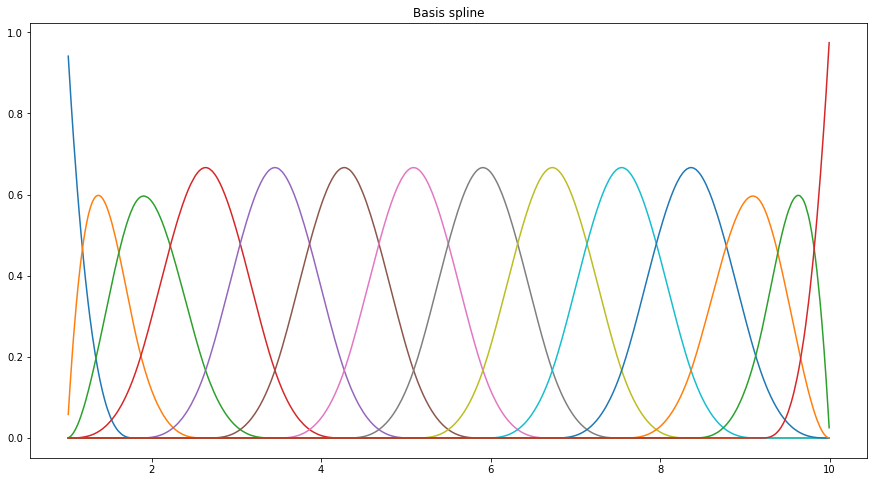

Response type: Gaussian


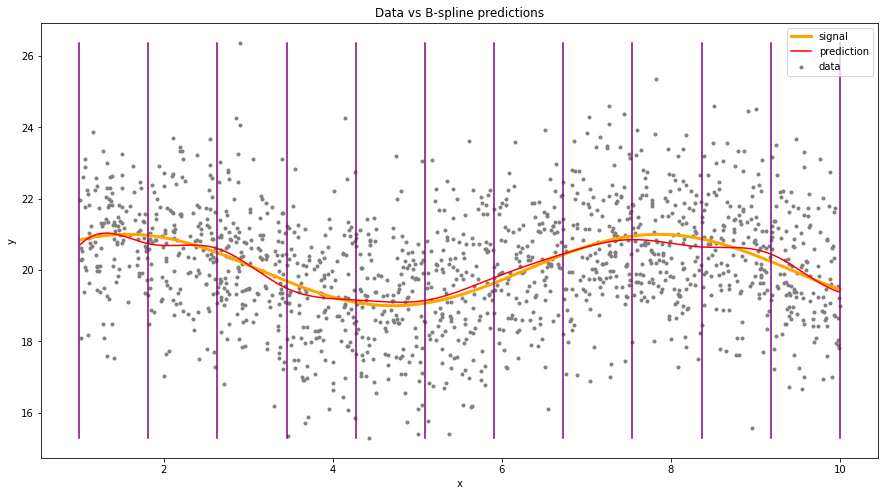

Residual sum of squares: 3344.7665542775094


In [129]:
#  Initialize the set of basis
spline = B_spline(data, K=10, order=3)
print(f'Parameters: Freedom_degree = {spline.df}, Polynomial_order = {spline.order}, Internal_knots = {spline.K}')

#  Check for the sum of component to be consistent to what we expect
print(f'Check ({np.all(spline.base.sum(axis=1))}): sum of components equal to 1')

#  Fit a GLM model to fit the data properly
spline.plotBasis()
result, RSS = spline.fitGLM(response=family, verbose=False, show=True, showKnots=True)
print(f'Residual sum of squares: {RSS}')

## Phase 3: Introducing the knots position optimization

Parameters: Freedom_degree = 14, Polynomial_order = 3, Internal_knots = 10


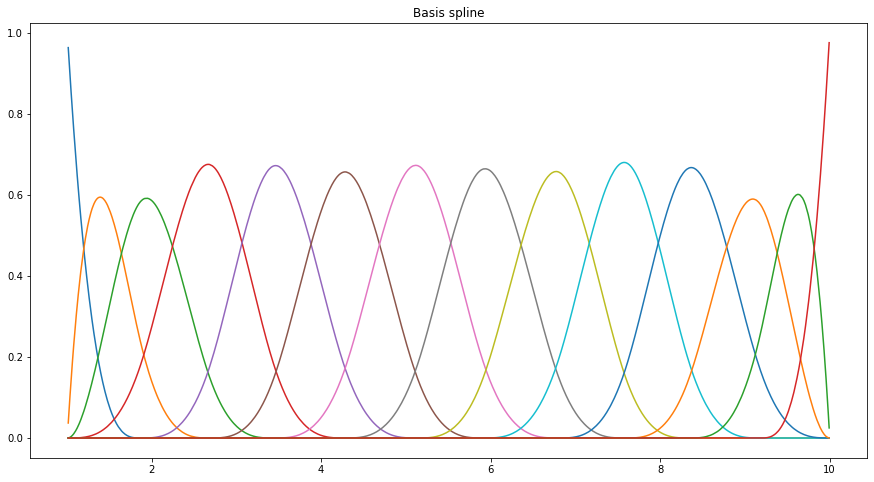

Response type: Gaussian


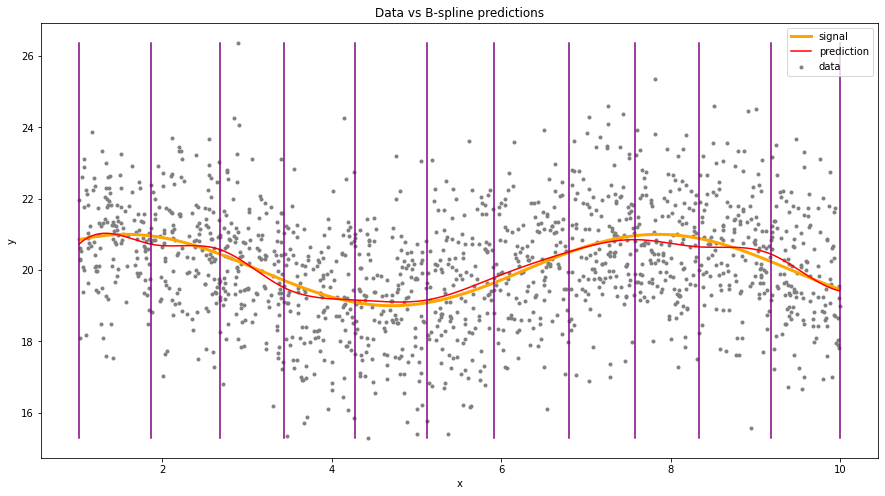

Residual sum of squares: 3344.47281233019


In [130]:
#  Initialize the set of basis
spline_opt = B_spline(data, K=10, order=3, K_optimization=True)
print(f'Parameters: Freedom_degree = {spline_opt.df}, Polynomial_order = {spline_opt.order}, Internal_knots = {spline_opt.K}')

#  Fit a GLM model again to fit the data
spline_opt.plotBasis()
result, RSS = spline_opt.fitGLM(response=family, verbose=False, show=True, showKnots=True)
print(f'Residual sum of squares: {RSS}')

## Phase 4: Check for the model stability

Parameters: Freedom_degree = 9, Polynomial_order = 3, Internal_knots = 5, Optimized: True
Number of fits: 5, Mean RSS: 2656.2811304871393, StdDev RSS: 70.55989156650264


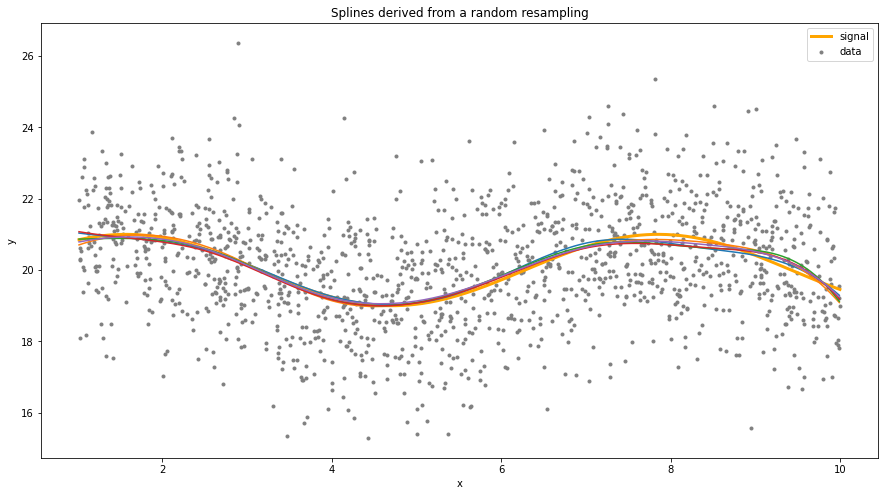

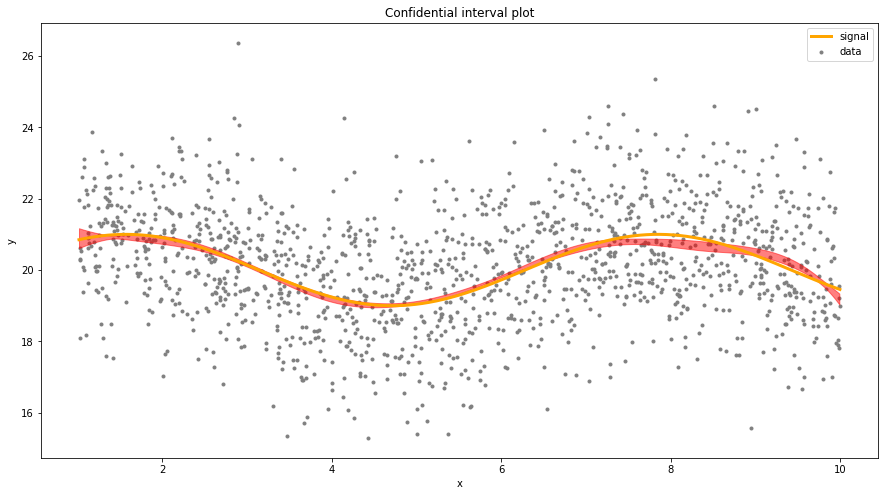

In [131]:
def checkStability(data, K, order, err_fam='gaussian', n_out=0, n_fits=1, opt=False, verbose=False, show=False, showConf=False):
    """
    data -> collection of data in my_data form
    n_out -> Number of out-of-bunch for random sampling Cross validation
    n_fits -> Number of fits to be executed
    opt -> Knot position optimization
    """
    
    sliced_data = [data.shrinked_Dataset(n_out) for i in range(n_fits)]

    #  Initialize the set of basis for each spline
    splines = [B_spline(data, K=K, order=order, K_optimization=opt) for data in sliced_data]

    #  Fit the GLM models
    res = [spline.fitGLM(response=err_fam, verbose=False, show=False) for spline in splines]
    RSS_mean = sum([r[1] for r in res]) / len(res)
    RSS_devst = math.sqrt( sum([(r[1] - RSS_mean) ** 2 for r in res]) / len(res) )

    
    if verbose:
        print(f'Parameters: Freedom_degree = {splines[0].df}, '+\
          f'Polynomial_order = {splines[0].order}, Internal_knots = {splines[0].K}, Optimized: {splines[0].opt}')
        print(f'Number of fits: {n_fits}, Mean RSS: {RSS_mean}, StdDev RSS: {RSS_devst}')
        
        Y = np.array([spline.predict(data.x) for spline in splines])
        Y_mean = np.sum(Y, axis=0)/len(Y)
        Y_devst = np.sqrt(np.sum(np.power(Y.T - Y_mean[:, None], 2), axis=1) / len(Y))
        
    if show:
        data.plot()
        for y in Y[:]:
            plt.plot(data.x[:-1], y)
        plt.title("Splines derived from a random resampling")
        plt.legend()
        plt.show()
    
    if showConf:
        data.plot()
        plt.fill_between(data.x[:-1], (Y_mean-1.96*Y_devst), (Y_mean+1.96*Y_devst), color='r', alpha=.5)
        plt.title("Confidential interval plot")
        plt.legend()
        plt.show()
        
    else:
        print(f'Parameters: Polynomial_order = {splines[0].order}, Internal_knots = {splines[0].K}'+\
          f' ->  Mean RSS: {RSS_mean}, StdDev RSS: {RSS_devst}')
        
    return RSS_mean, RSS_devst, splines[0].order, splines[0].K

params = checkStability(data, err_fam=family, K=5, order=3, n_out=300, n_fits=5, 
                        opt=True, verbose=True, show=True, showConf=True)


## Phase 5: Finding the best number of knots

Parameters: Polynomial_order = 3, Internal_knots = 1 ->  Mean RSS: 2895.906227240494, StdDev RSS: 60.22670408727925
Parameters: Polynomial_order = 3, Internal_knots = 2 ->  Mean RSS: 2845.9780820989936, StdDev RSS: 49.382602796569344
Parameters: Polynomial_order = 3, Internal_knots = 3 ->  Mean RSS: 2845.8879481423105, StdDev RSS: 34.34661014494015
Parameters: Polynomial_order = 3, Internal_knots = 4 ->  Mean RSS: 2836.713659569351, StdDev RSS: 36.32248851665255
Parameters: Polynomial_order = 3, Internal_knots = 5 ->  Mean RSS: 2795.304999249139, StdDev RSS: 41.15730827921972
Parameters: Polynomial_order = 3, Internal_knots = 6 ->  Mean RSS: 2805.055615818744, StdDev RSS: 61.94449138658202
Parameters: Polynomial_order = 3, Internal_knots = 7 ->  Mean RSS: 2819.077261079088, StdDev RSS: 37.15994207615048
Parameters: Polynomial_order = 3, Internal_knots = 8 ->  Mean RSS: 2828.357783018756, StdDev RSS: 46.188962212283926
Parameters: Polynomial_order = 3, Internal_knots = 9 ->  Mean RSS: 2

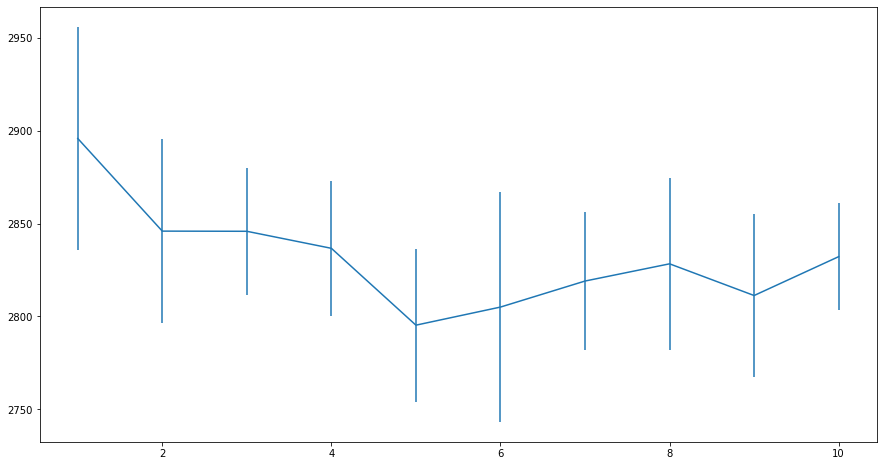

Lowest RSS mean at the K value of 5


In [114]:
def find_knotNum(data, err_fam='gaussian', order=3, n_out=50, n_fits=15, opt=True, tolerance=6, maxK=30, show=True):
    """
    Try to find the best number of knots keeping the RSS mean as target.
    data -> collection of data in my_data form
    n_out -> Number of out-of-bunch for random sampling Cross validation
    n_fits -> Number of fits to be executed
    opt -> Knot position optimization
    tolerance -> method will stop when 6 consecutive estimations yield to a worse RSS mean
    maxK -> maximum number for K
    show -> True if the graph should be displayed
    """
    goodness = {}
    K = 1
    far_fromMin = 0
    min_ = 10**99
    bestK = 1
    while far_fromMin < tolerance and K < maxK:
        params = checkStability(data, K=K, order=order, n_out=n_out, n_fits=n_fits, opt=opt, verbose=False)
        goodness[K] = (params[0], params[1])  #  saving RSS mean and RSS dev_std
        if params[0] < min_:
            far_fromMin = 0
            min_ = params[0]
            bestK = K
        far_fromMin += 1
        K += 1
    
    if show:
        plt.errorbar(goodness.keys(), [el[0] for el in goodness.values()], yerr=[el[1] for el in goodness.values()])
        plt.show()
    print(f'Lowest RSS mean at the K value of {bestK}')

    
find_knotNum(data, err_fam=family, order=3, n_out=300, n_fits=15, tolerance=6, maxK=20, show=True)

## Phase 6: Test the model on real data

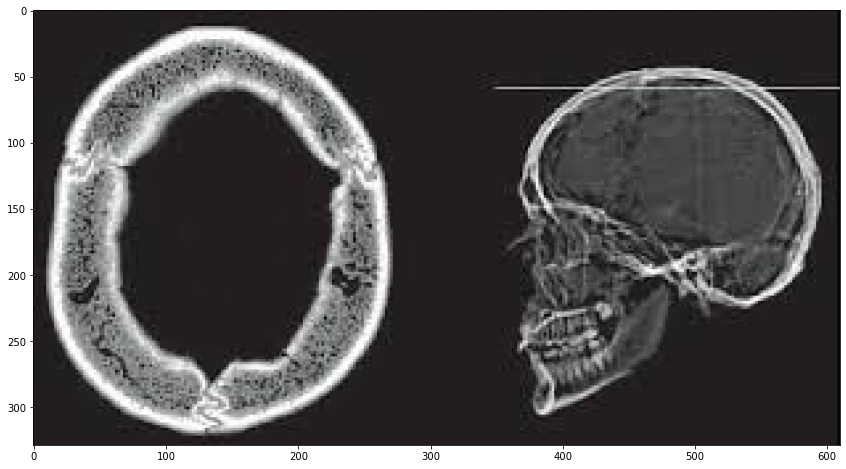

Image size: (329, 305)


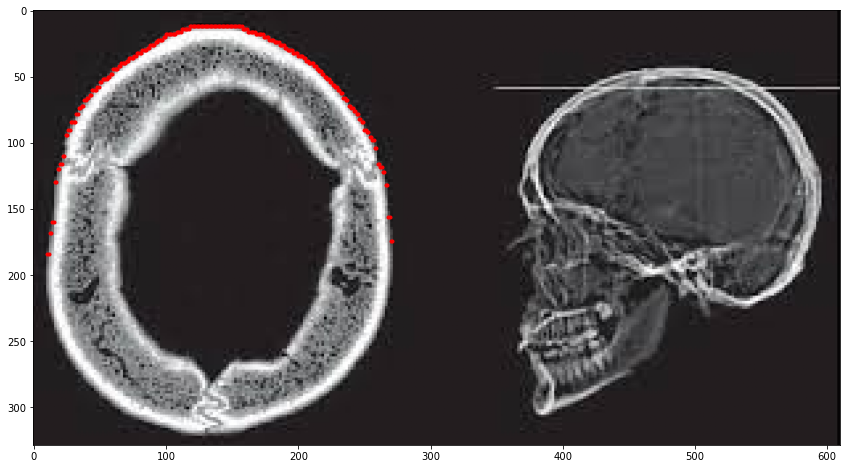

In [50]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#  Import of the medical image (random tac from public repositories)
row_img = mpimg.imread('tac.png')
plt.imshow(row_img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

#  Cut on the not interesting section of the image
img = row_img[:, :int(row_img.shape[1]/2)]
img = rgb2gray(img)
print(f'Image size: {img.shape}')

#  Selection of the representative pixels for the cranial border.
#  Only those first pixels that exceed the percentage p of intensity have been considered.
p = 0.3
x = []
y = []
j = -1
for col in img.T:
    j += 1
    for i in range(len(col)):
        if col[i] > p:
            x.append(j)
            y.append(i)
            break
x = np.array(x)
y = np.array(y)

#  Overlapping between the last selection and the original image
plt.imshow(row_img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.scatter(x, y, marker='.', c='r')
plt.show()


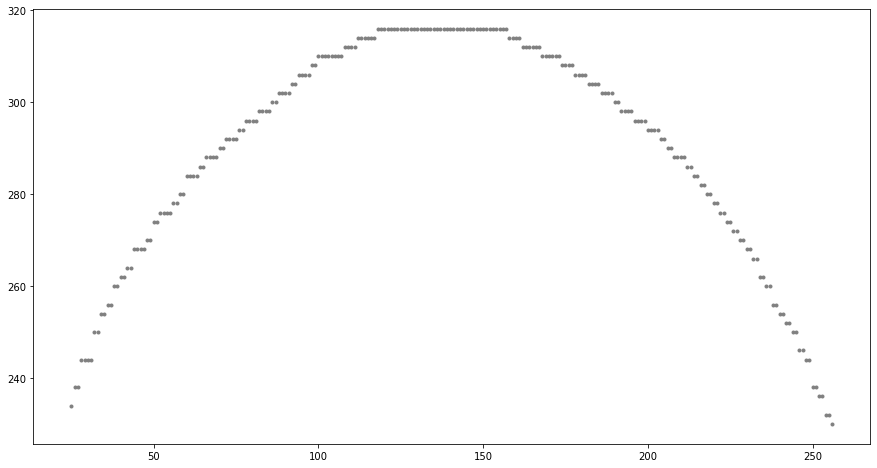

In [51]:
#  Selection of the frontal lobe. This kind of feature extraction doesn't work with high sloped superficies
#  (in order to fix the problem we need to just rotate the image and fit several times the same model).
offset = 15
x = x[offset:-offset]
y = y[offset:-offset]
y = len(col) -1 -y
plt.scatter(x, y, marker='.', c='gray')
plt.show()

Parameters: Polynomial_order = 3, Internal_knots = 1 ->  Mean RSS: 336.57169566179346, StdDev RSS: 13.00179563848543
Parameters: Polynomial_order = 3, Internal_knots = 2 ->  Mean RSS: 297.5452056229134, StdDev RSS: 8.686946633003341
Parameters: Polynomial_order = 3, Internal_knots = 3 ->  Mean RSS: 197.75814487411833, StdDev RSS: 8.044258044678227
Parameters: Polynomial_order = 3, Internal_knots = 4 ->  Mean RSS: 165.8470394388029, StdDev RSS: 5.2817610479878265
Parameters: Polynomial_order = 3, Internal_knots = 5 ->  Mean RSS: 165.35648766464627, StdDev RSS: 5.9436763332187725
Parameters: Polynomial_order = 3, Internal_knots = 6 ->  Mean RSS: 162.65864170732868, StdDev RSS: 3.283582555283131
Parameters: Polynomial_order = 3, Internal_knots = 7 ->  Mean RSS: 151.9771549549324, StdDev RSS: 7.515105116676635
Parameters: Polynomial_order = 3, Internal_knots = 8 ->  Mean RSS: 155.60407830200305, StdDev RSS: 5.632753548267986
Parameters: Polynomial_order = 3, Internal_knots = 9 ->  Mean RSS

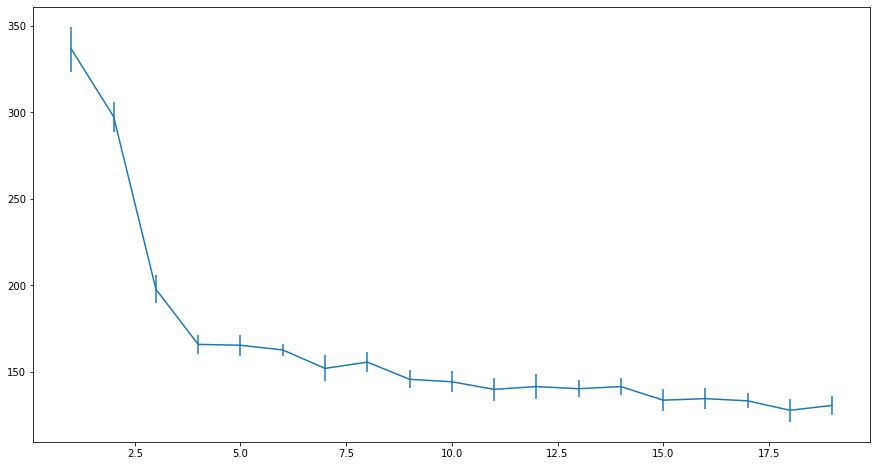

Lowest RSS mean at the K value of 18


In [126]:
#  Character of the response distribution: it's pretty much likely that the response follows a poisson distribution 
#  due to the upward spread of the noise.
family = 'poisson'

#  Creation of the my_data class with real data
r_data = my_data(x, y)

find_knotNum(r_data, order=3, err_fam=family, n_out=20, n_fits=15, tolerance=6, maxK=20, show=True)

We can notice a decreasing value of the RSS as a function of the number of knots. Nevertheless, more complexity can always lead to lowest objective values, despite the parallel decrease in generalization power. From the graph above, it seems reasonable to fix just 4 knots as a good compromise between complexity and RSS.

Parameters: Freedom_degree = 17, Polynomial_order = 12, Internal_knots = 4
Response type: Poisson


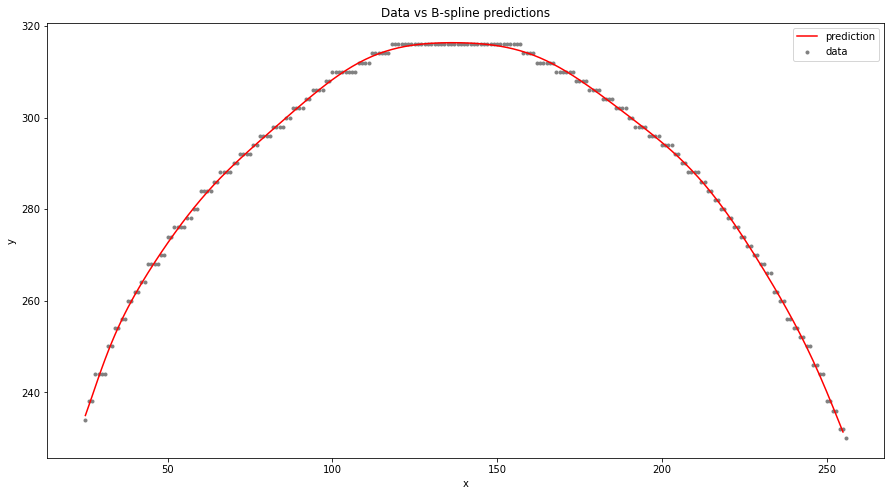

Residual sum of squares: 158.39180666711482


In [53]:
#  Initialize the set of basis
r_spline = B_spline(r_data, K=4, order=12)
print(f'Parameters: Freedom_degree = {r_spline.df}, Polynomial_order = {r_spline.order}, Internal_knots = {r_spline.K}')

#  Fit a GLM model to fit the data properly
result, RSS = r_spline.fitGLM(response=family, verbose=False, show=True)
print(f'Residual sum of squares: {RSS}')

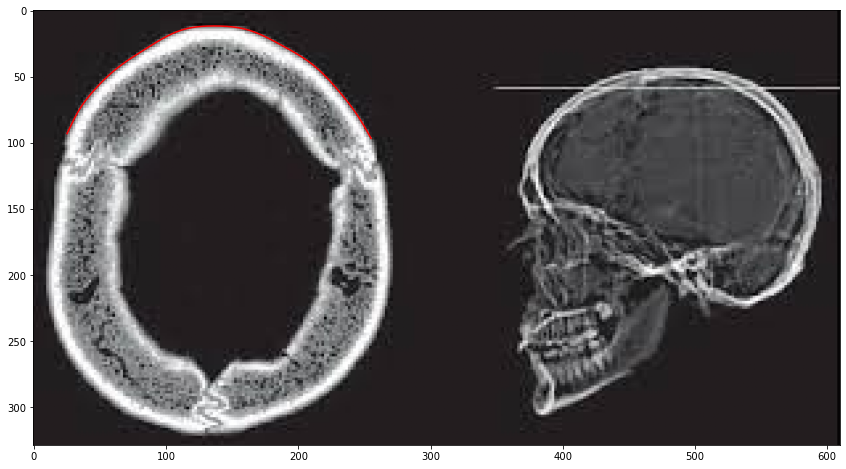

In [54]:
plt.imshow(row_img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.plot(r_spline.dataset.x[:-1], img.shape[0] - 1 - r_spline.predicted[:-1], c='r')
plt.show()

As we see above, the results are stunning!